In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/Users/liuxiaohui/autolens/autolens_workspace_1.15.3
Working Directory has been set to `/Users/liuxiaohui/autolens/autolens_workspace_1.15.3`


## generate the mock data

In [2]:
dataset_type = "interferometer"
dataset_name = "mass_sie__source_sersic"

In [3]:
dataset_path = path.join("dataset", dataset_type, dataset_name)

In [4]:
grid = al.Grid2DIterate.uniform(
    shape_native=(800, 800), pixel_scales=0.05, fractional_accuracy=0.9999
)

In [5]:
uv_wavelengths_path = path.join("dataset", dataset_type, "uv_wavelengths")
uv_wavelengths = al.util.array_1d.numpy_array_1d_from_fits(
    file_path=path.join(uv_wavelengths_path, "sma.fits"), hdu=0
)

In [6]:
simulator = al.SimulatorInterferometer(
    uv_wavelengths=uv_wavelengths,
    exposure_time=300.0,
    background_sky_level=0.1,
    noise_sigma=0.1,
    transformer_class=al.TransformerNUFFT,
)

In [7]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

In [8]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

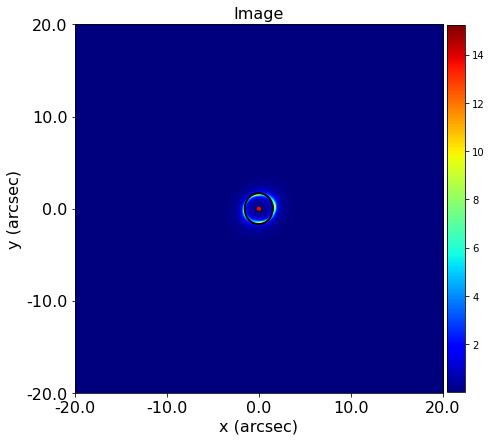

In [10]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)

In [11]:
interferometer = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

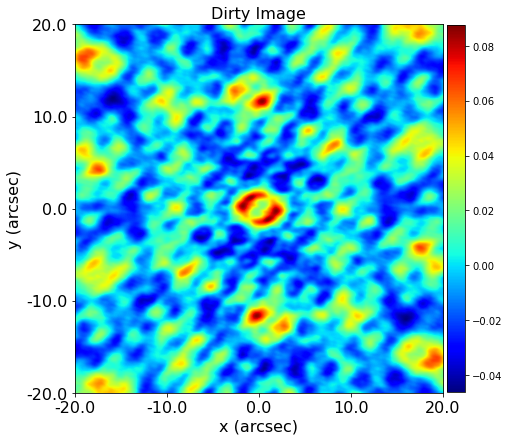

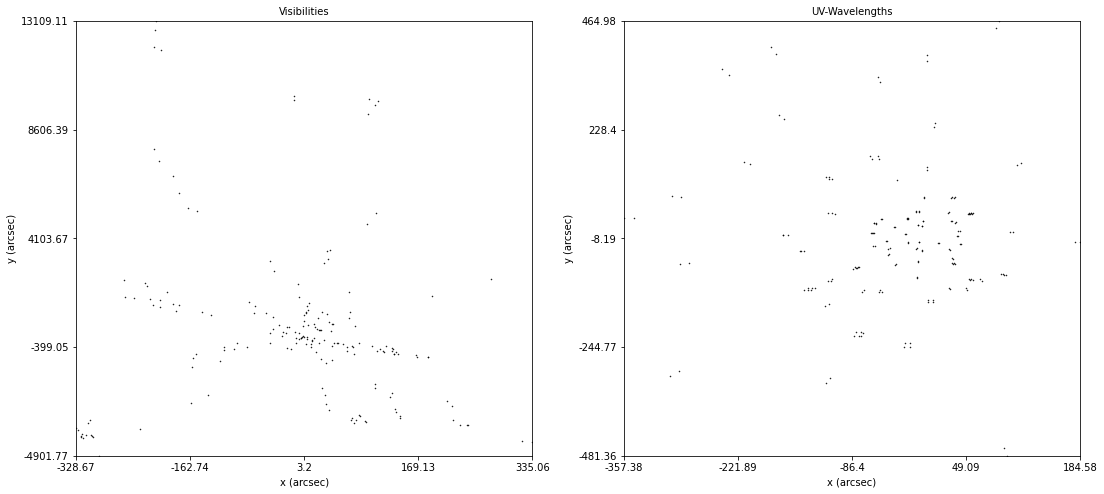

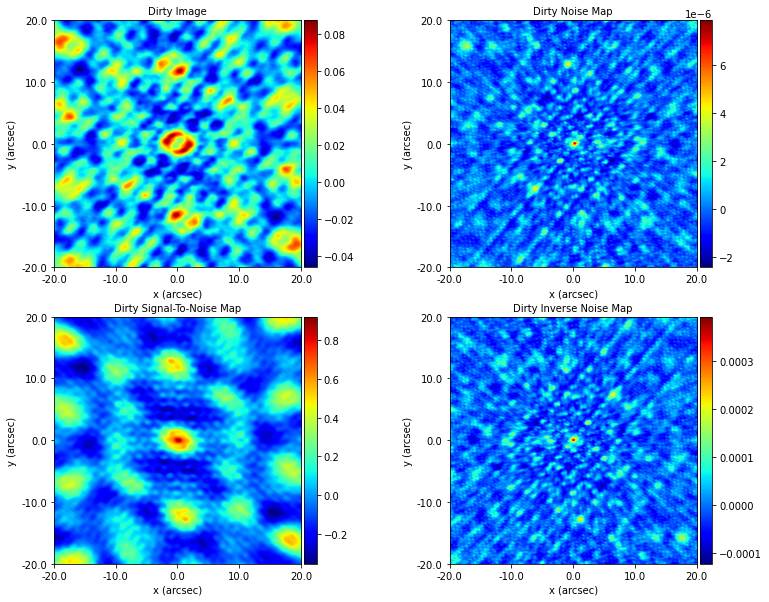

In [12]:
interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.figures_2d(dirty_image=True)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

In [13]:
interferometer.output_to_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    overwrite=True,
)

## modeling with mock data

In [18]:
import autofit as af

real_space_mask = al.Mask2D.unmasked(
    shape_native=(256, 256), pixel_scales=0.05
)

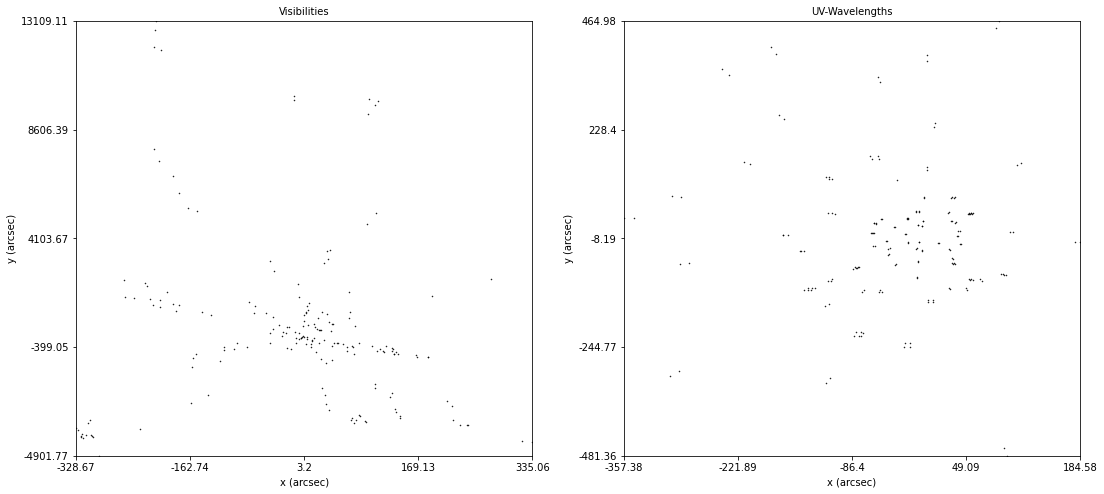

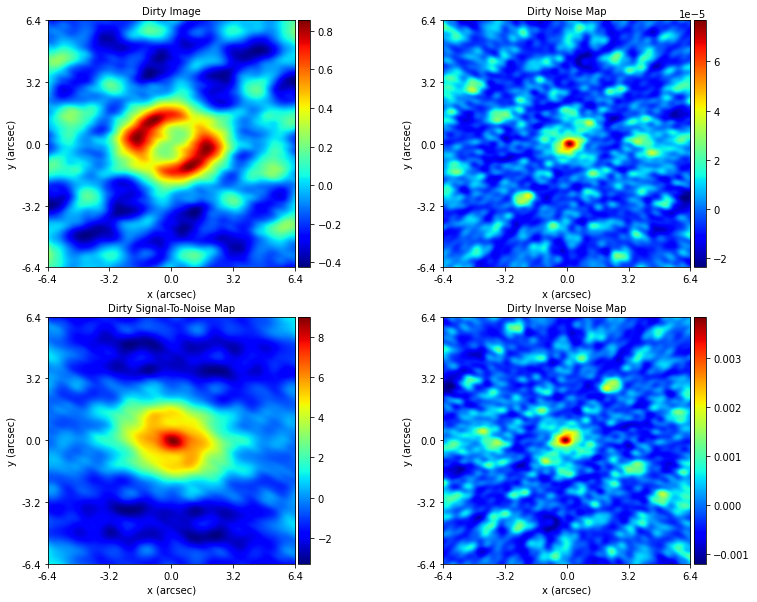

In [19]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "interferometer", dataset_name)

interferometer = al.Interferometer.from_fits(
    visibilities_path=path.join(dataset_path, "visibilities.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    uv_wavelengths_path=path.join(dataset_path, "uv_wavelengths.fits"),
    real_space_mask=real_space_mask,
)

interferometer_plotter = aplt.InterferometerPlotter(interferometer=interferometer)
interferometer_plotter.subplot_interferometer()
interferometer_plotter.subplot_dirty_images()

In [20]:
settings_interferometer = al.SettingsInterferometer(
    transformer_class=al.TransformerNUFFT
)

In [21]:
lens = af.Model(
    al.Galaxy, redshift=0.5, mass=al.mp.EllIsothermal, shear=al.mp.ExternalShear
)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

In [30]:
search = af.DynestyStatic(
    path_prefix=path.join("interferometer"),
    name="mass[sie]_source[bulge]",
    unique_tag=dataset_name,
    nlive=50,
    number_of_cores=6,
)

In [31]:
analysis = al.AnalysisInterferometer(dataset=interferometer)

In [32]:
result = search.fit(model=model, analysis=analysis)

2021-06-23 14:33:59,239 - process 0 - INFO - created
2021-06-23 14:33:59,241 - process 1 - INFO - created
2021-06-23 14:33:59,242 - process 2 - INFO - created
2021-06-23 14:33:59,243 - process 3 - INFO - created
2021-06-23 14:33:59,244 - process 4 - INFO - created
2021-06-23 14:33:59,245 - process 5 - INFO - created
627it [01:17,  8.10it/s, +50 | bound: 77 | nc: 1 | ncall: 5055 | eff(%): 13.393 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
1211it [01:29, 13.60it/s, +50 | bound: 186 | nc: 1 | ncall: 10056 | eff(%): 12.540 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
1969it [01:18, 25.01it/s, +50 | bound: 305 | nc: 1 | ncall: 15060 | eff(%): 13.406 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
2671it [01:23, 31.80it/s, +50 | bound: 421 | nc: 1 | ncall: 20069 | eff(%): 13.558 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.05

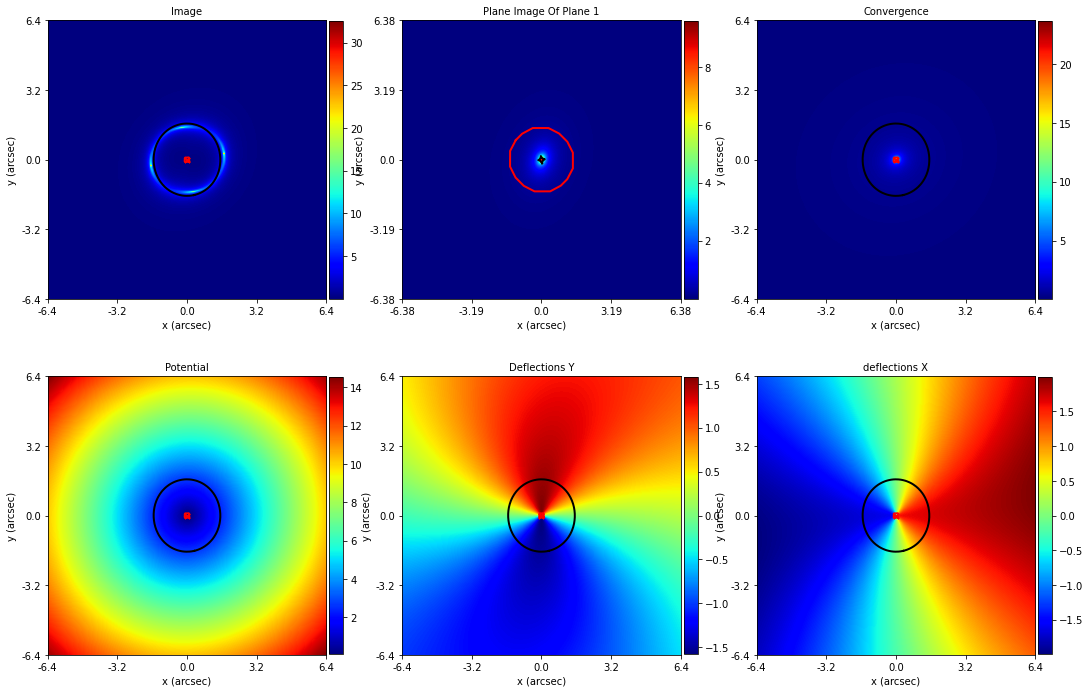

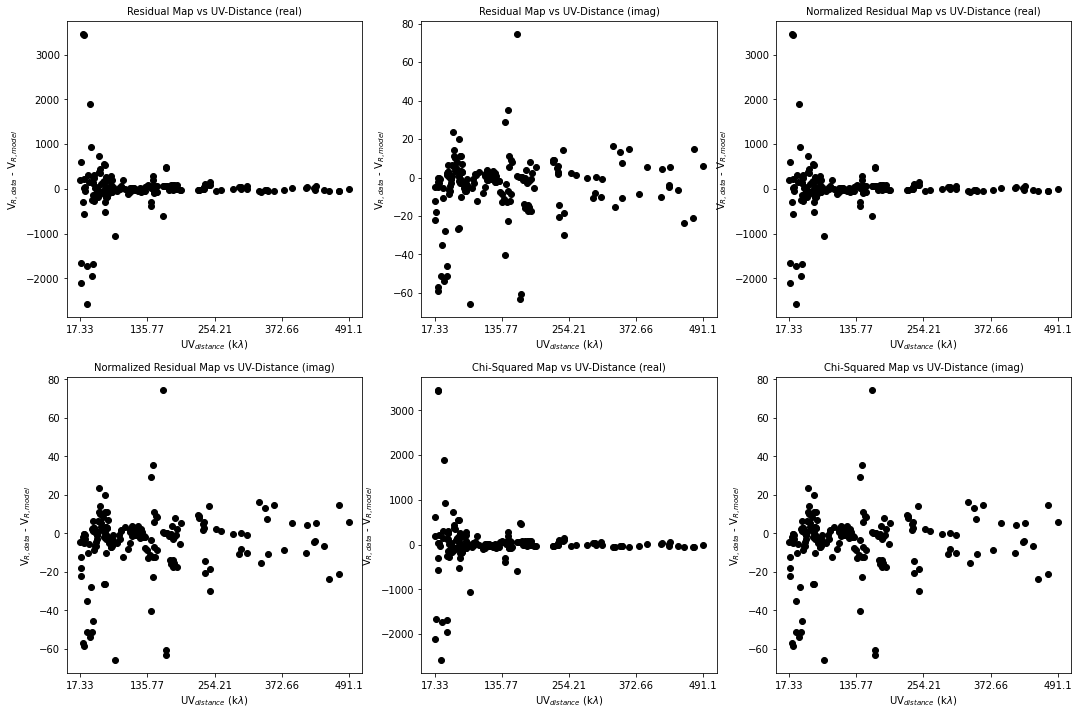

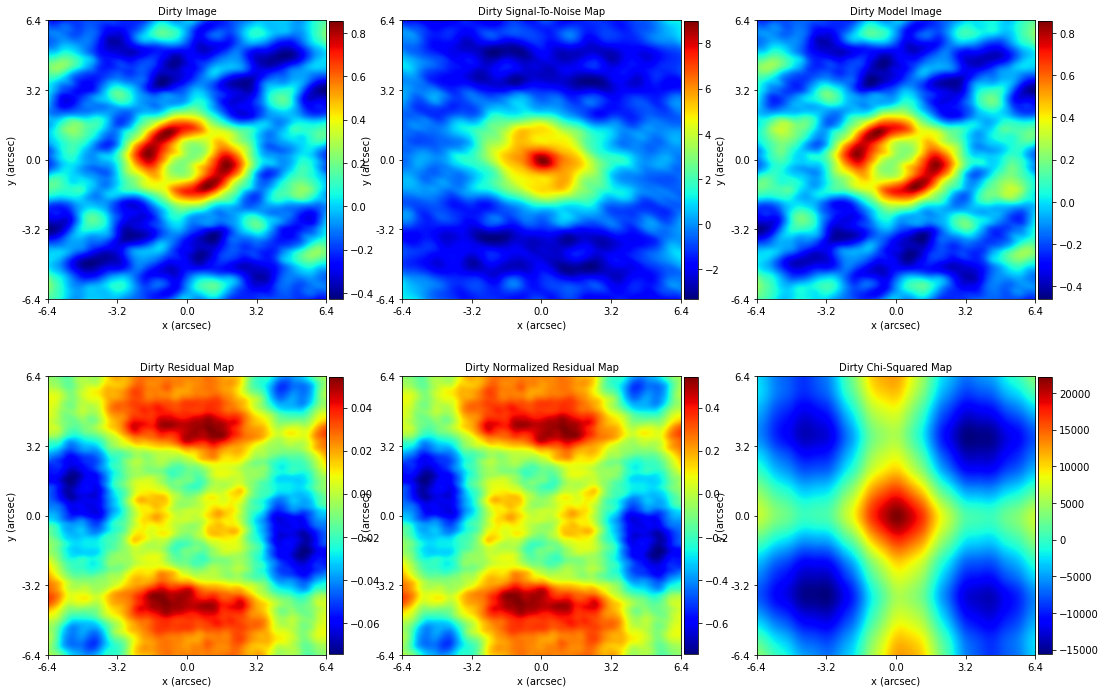

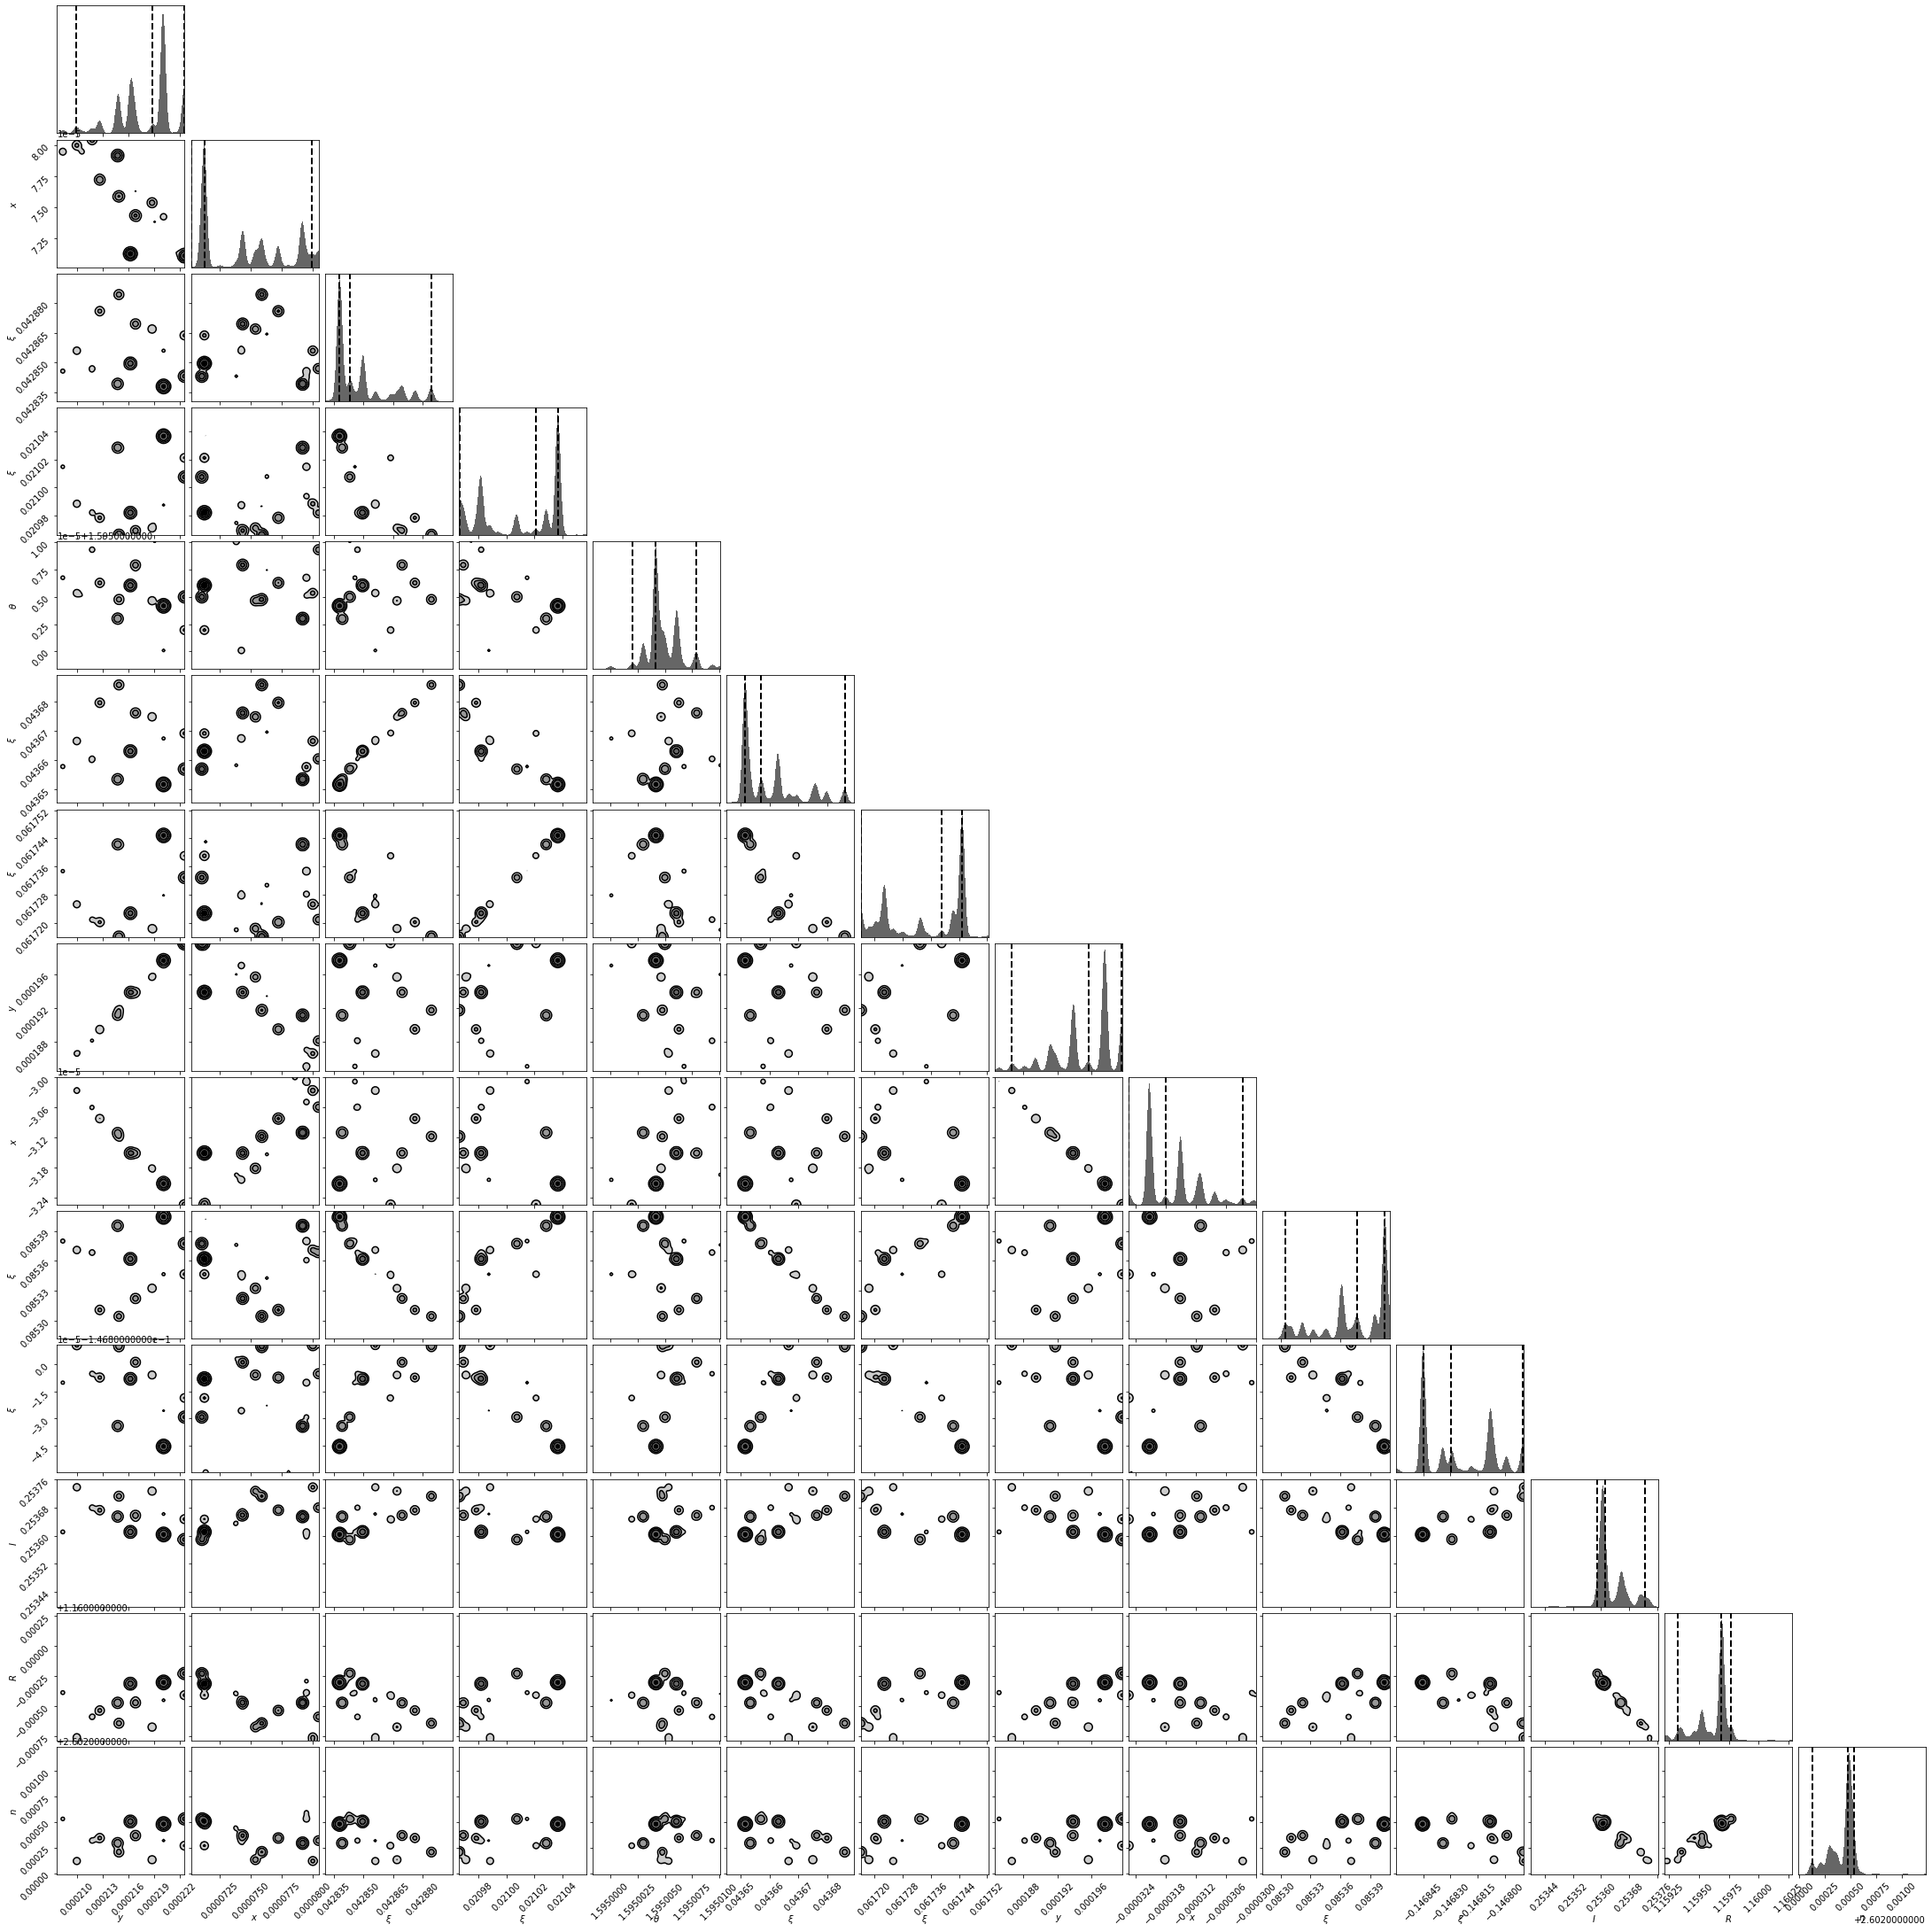

In [33]:
print(result.max_log_likelihood_instance)

tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=real_space_mask.masked_grid_sub_1
)
tracer_plotter.subplot_tracer()
fit_interferometer_plotter = aplt.FitInterferometerPlotter(
    fit=result.max_log_likelihood_fit
)
fit_interferometer_plotter.subplot_fit_interferometer()
fit_interferometer_plotter.subplot_fit_dirty_images()

dynesty_plotter = aplt.DynestyPlotter(samples=result.samples)
dynesty_plotter.cornerplot()

In [37]:
print('The Maximum Log Likelihood is: ',result.log_likelihood)

The Maximum Log Likelihood is:  -2915013641.4005766


## result when input real parameters from FitInterferometer

In [39]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, angle=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitInterferometer(interferometer=interferometer, tracer=tracer)

print('The Log Likelihood is: ',fit.log_likelihood)

The Log Likelihood is:  -3075186263.540647


## You can see that the log likelihood from modeling is larger than which from FitInterferometer. Something may be wrong I think. 